In [49]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from brick.azr import AZR
from lmfit import Parameters, Minimizer
from IPython.display import display, Math

method = "leastsq"

# Normalization parameter map : { index : (value, error) } (in AZURE2 order)
norms = { 0: (1, 0.05), 1: (1, 0.069), 2: (1, 0.079), 3: (1, 0.085), 4: (1, 0.05), 5: (1, 0.10), 6: (1, 0.10) }

In [2]:
# We read the .azr file
azr = AZR('12c_pg.azr')
azr.ext_capture_file='output/intEC.dat'

In [33]:
# We get the initial values from AZURE2
theta0 = azr.config.get_input_values()

# Get number of data
output = np.vstack( azr.predict( theta0, dress_up=False ) )
ndata = output.shape[0]

# Now we loop over the data files to take their order and length and cut the output
index, data = 0, { }
for segment in azr.config.data.segments:
    data[segment.filename] = output[index:index+len(segment.values)]
    index += len(segment.values)

# Number of R-matrix parameters (without normalization)
ntheta = len(theta0) - len(norms)

In [4]:
# Callback function to print the chi2 at each iteration
def callback(params, iter, resid):
    if( iter % 10 == 0 ): print("Iteration: {:6d} it Chi2: {:15.4f}".format( iter, np.sum(resid**2) ), end="\r")
    pass

# Add normalization to chi2
def normalization( theta ):
    # We use ntheta to loop on normalization parameters only
    norm = [ (theta[ntheta + i] - norms[i][0]) / norms[i][1] for i in norms ]
    return norm

# Calculated squared residuals
def least_squares( theta ):
    output = np.vstack(azr.predict(theta, dress_up=False))
    mu, y, dy = output[:, 4], output[:, 7], output[:, 8]    
    chi2 = (y - mu) / dy
    return chi2

#Function to minimize
def func( theta ):
    theta = list( theta.valuesdict().values() )
    residuals = np.concatenate( (least_squares( theta ), normalization( theta )) )
    return residuals

In [7]:
# Preparing the parameters
params = Parameters()
for i in range(len(theta0)):
    if( i == 0 ):           params.add( "param_{}".format(i), value=theta0[i], vary=True )
    elif( i in [1,5,11] ):  params.add( "param_{}".format(i), value=theta0[i], vary=True )
    else:                   params.add( "param_{}".format(i), value=theta0[i], vary=True )

# Starting the minimization  
mini = Minimizer( func, params, iter_cb=callback )
out = mini.minimize( method="leastsq" )

In [52]:
# Print the chi2 from func
chi2 = np.sum( func(out.params)**2 )
chi2_red = chi2 / (ndata - len(out.params))
display(Math("\chi ^2 = {:20.2f} \ \chi ^2 _r = {:20.2f}".format(chi2, chi2_red)))

# Print the minimizer result
for i in range(len(theta0)):
    label, value, error = azr.config.labels[i], out.params["param_{}".format(i)].value, out.params["param_{}".format(i)].stderr
    if( error == None ): error = 0
    display(Math("{}: {:20.6f} +/- {:15.6f}".format(label, value, error)))

# Write the results to a file
with open( "results/best-{}.txt".format(method), "w" ) as f:
    # Write a header with the chi2 and chi2_red, number of iterations, number of data and number of parameters
    f.write("# Chi2 = {} \n".format(chi2))
    f.write("# Chi2_red = {} \n".format(chi2_red))
    f.write("# Iterations = {} \n".format(out.nfev))
    f.write("# Data = {} \n".format(ndata))
    f.write("# Parameters = {} \n".format(len(out.params)))
    # Write the parameters
    for i in range(len(theta0)):
        label, value, error = azr.config.labels[i], out.params["param_{}".format(i)].value, out.params["param_{}".format(i)].stderr
        if( error == None ): error = 0
        f.write("{}: {} +/- {} \n".format(label, value, error))

with open( "results/covariance-{}.txt".format(method), "w" ) as f:
    for i in range(len(theta0)):
        for j in range(len(theta0)):
            f.write("{:15.6f} ".format(out.covar[i,j]))
        f.write("\n")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

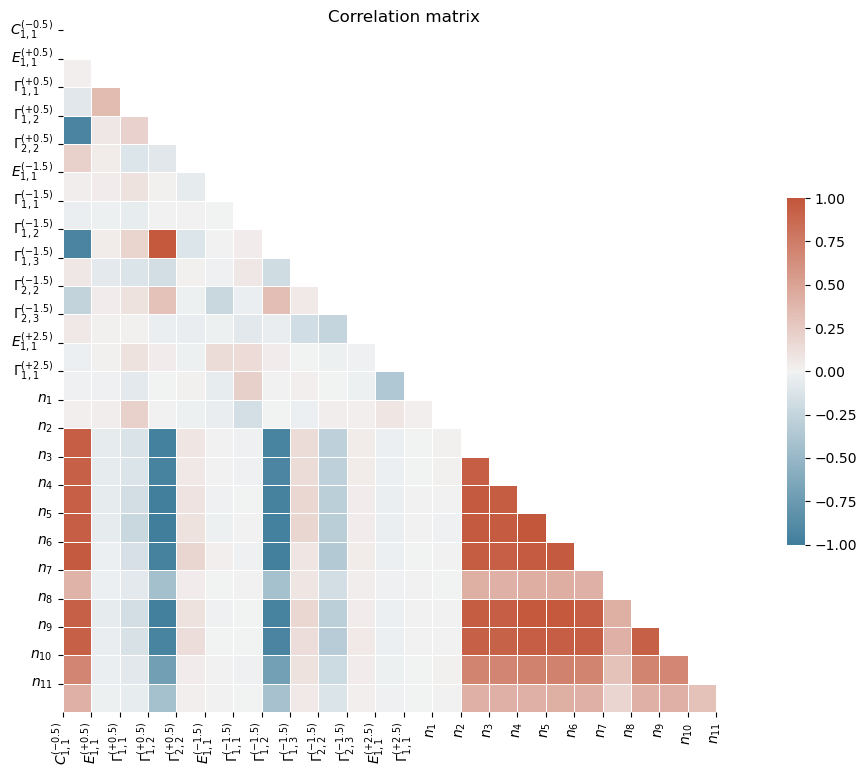

In [31]:
# Calculate the correlation matrix
correlation = np.zeros( (len(theta0), len(theta0)) )
for i in range(len(theta0)):
    for j in range(len(theta0)):
        correlation[i,j] = out.covar[i,j] / (out.params["param_{}".format(i)].stderr * out.params["param_{}".format(j)].stderr)
        pass
    pass

# Plot only lower triangle
for i in range(len(theta0)):
    for j in range(len(theta0)):
        if( i <= j ): correlation[i,j] = 0
        pass
    pass

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Set title and labels
plt.title("Correlation matrix")

# Change xticks and yticks
plt.xticks(range(len(theta0)), azr.config.labels, rotation=90)
plt.yticks(range(len(theta0)), azr.config.labels, rotation=0)

plt.show( )

In [32]:
# Get 1000 samples from the covariance matrix
samples = np.random.multivariate_normal( list(out.params.valuesdict().values()), out.covar, 1000 )

100%|██████████| 1000/1000 [01:35<00:00, 10.43it/s]


In [47]:
# Function to cut the extrapolations between pp and pg channels
def cut( result ):
    samples = [ ]
    matrix = np.array( result )
    # Cut array in the points where the first column, thus the energy, decrease
    indexes = np.where( np.diff( matrix[:,0] ) < 0 )[0]
    for i in range( len(indexes) + 1 ):
        if( i == 0 ): samples.append( matrix[:indexes[i],] )
        elif( i == len(indexes) ): samples.append( matrix[indexes[i-1]+1:,] )
        else: samples.append( matrix[indexes[i-1]+1:indexes[i],] )
    return samples

# Calculate the xtrapolations
buckets = { "integral"           : [ ],
            "differential_0deg"  : [ ],
            "differential_55deg" : [ ],
            "differential_90deg" : [ ],
            "elastic_84deg"      : [ ],
            "elastic_114deg"     : [ ],
            "elastic_144deg"     : [ ] }

for sample in tqdm( samples ):

    # Extrapolate gives an array of extrapolations for each channel
    result = azr.extrapolate( sample, ext_capture_file="output/intEC.extrap" )

    # In each channel, the data are not divided per segment
    samples_pp = cut( result[0] )
    samples_pg = cut( result[1] )

    # Append the extrapolation to each segment in AZURE2 order
    buckets["integral"].append( samples_pg[0] )
    buckets["differential_0deg"].append( samples_pg[1] )
    buckets["differential_55deg"].append( samples_pg[2] )
    buckets["differential_90deg"].append( samples_pg[3] )
    buckets["elastic_84deg"].append( samples_pp[0] )
    buckets["elastic_114deg"].append( samples_pp[1] )
    buckets["elastic_144deg"].append( samples_pp[2] )

100%|██████████| 1000/1000 [01:32<00:00, 10.79it/s]


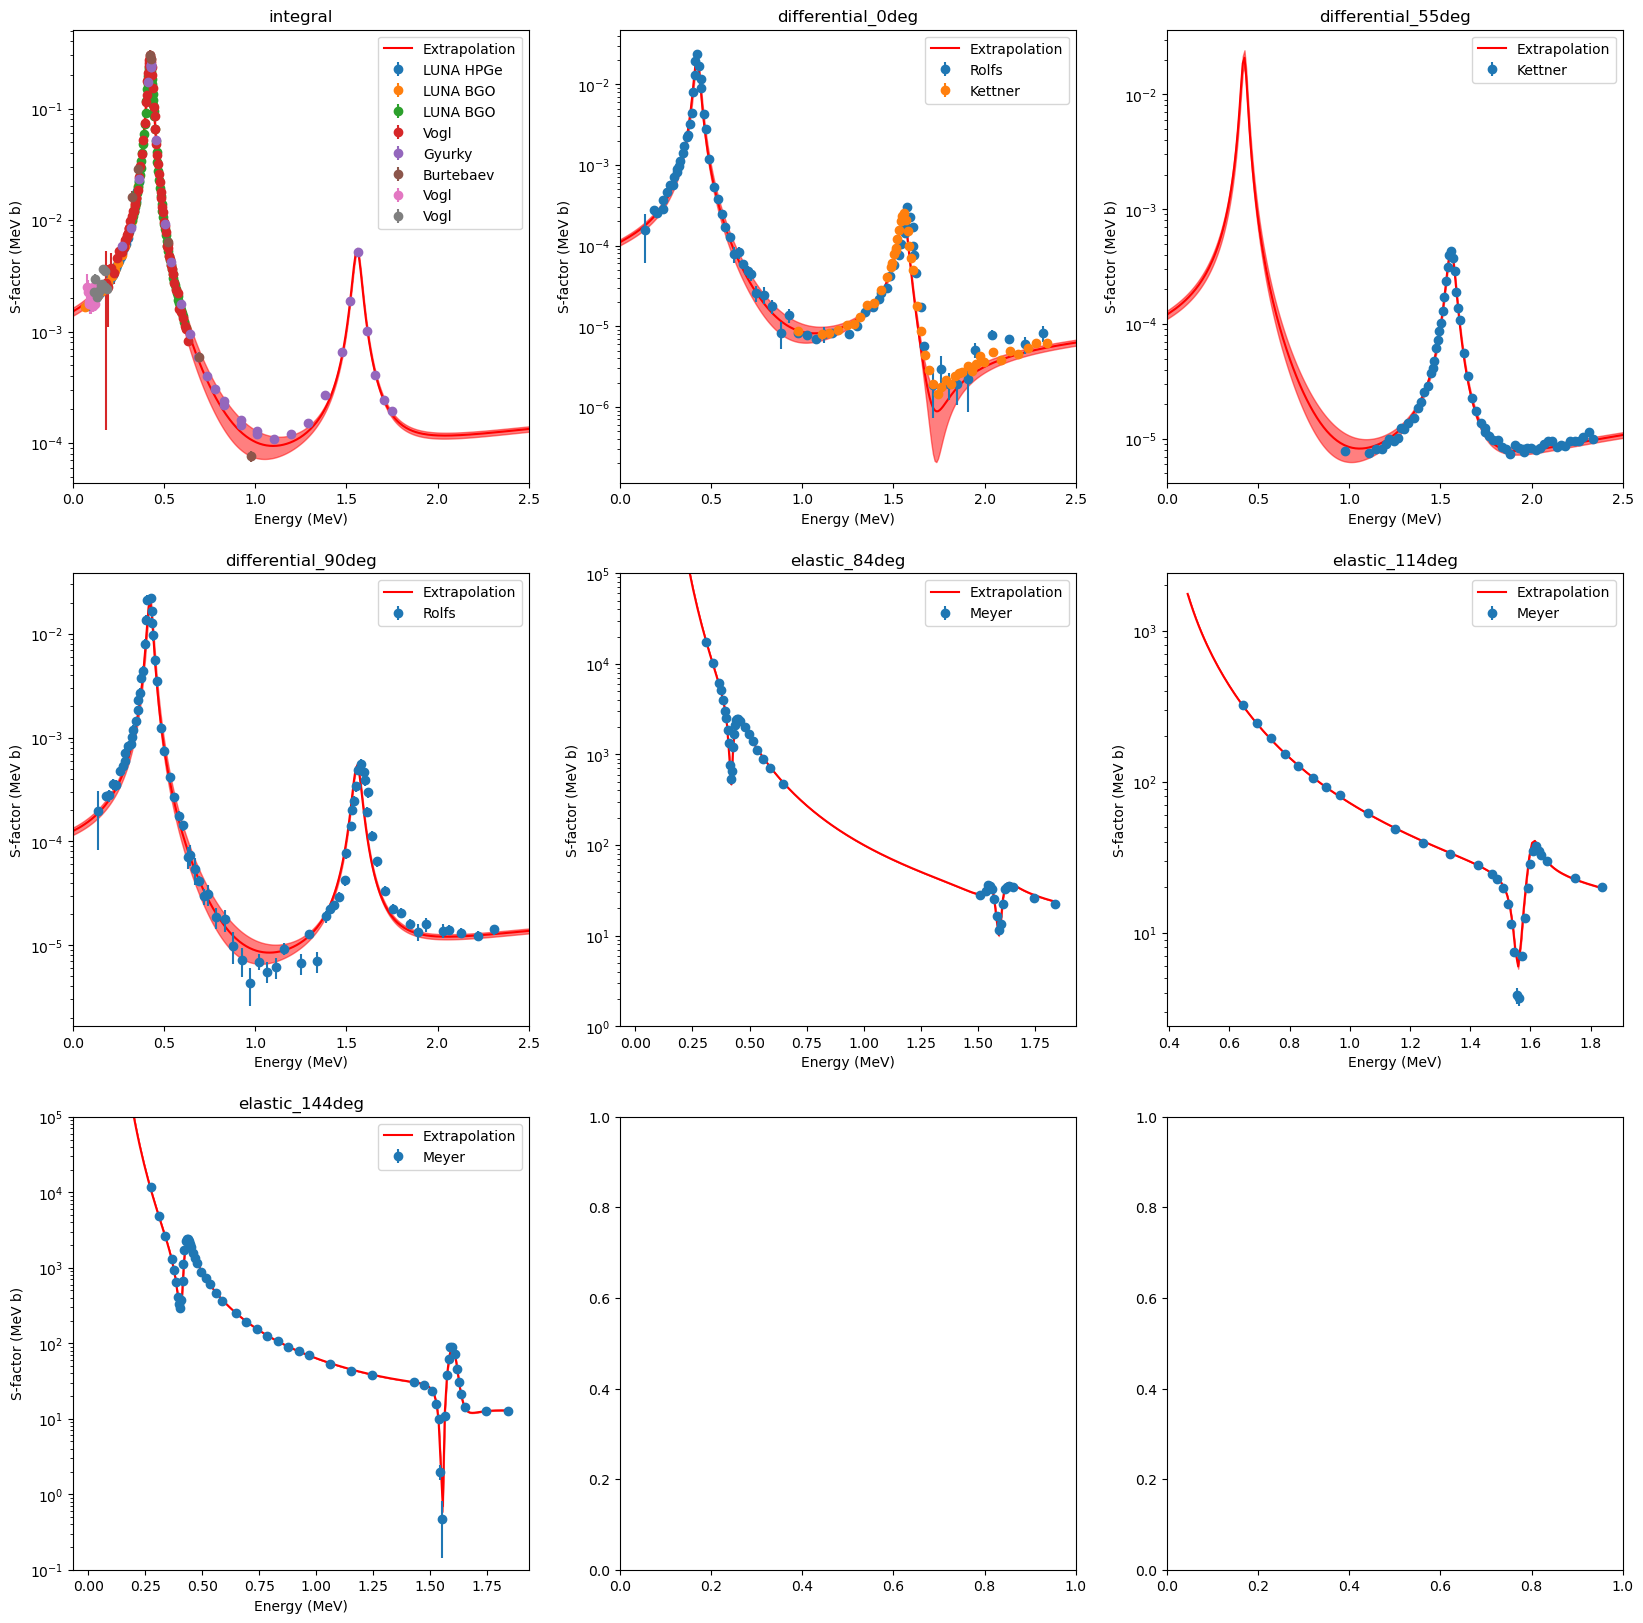

In [48]:
# Plotting the cross sections
fig, ax = plt.subplots( 3, 3, figsize=( 20, 20 ) )

for i, key in enumerate( buckets.keys( ) ):

    bucket = buckets[key]

    # Calculate the mean and standard deviation
    mean = np.mean( bucket, axis=0 )
    std  = np.std( bucket, axis=0 )
    
    ax[i//3, i%3].set_title( key )
    ax[i//3, i%3].set_xlabel( "Energy (MeV)" )
    ax[i//3, i%3].set_ylabel( "S-factor (MeV b)" )
    
    ax[i//3, i%3].plot( mean[:,0], mean[:,4], label="Extrapolation", color="red" )
    ax[i//3, i%3].fill_between( mean[:,0], mean[:,4] - std[:,4], mean[:,4] + std[:,4], color="red", alpha=0.5 )

    if( key == "integral" ): 
        ax[i//3, i%3].errorbar( data["skowronski_luna_hpge.dat"][:,0], data["skowronski_luna_hpge.dat"][:,4], yerr=data["skowronski_luna_hpge.dat"][:,5], label="LUNA HPGe", fmt="o" )
        ax[i//3, i%3].errorbar( data["skowronski_luna_bgo.dat"][:,0], data["skowronski_luna_bgo.dat"][:,4], yerr=data["skowronski_luna_bgo.dat"][:,5], label="LUNA BGO", fmt="o" )
        ax[i//3, i%3].errorbar( data["skowronski_fels.dat"][:,0], data["skowronski_fels.dat"][:,4], yerr=data["skowronski_fels.dat"][:,5], label="LUNA BGO", fmt="o" )
        ax[i//3, i%3].errorbar( data["vogl.dat"][:,0], data["vogl.dat"][:,7], yerr=data["vogl.dat"][:,8], label="Vogl", fmt="o" )
        ax[i//3, i%3].errorbar( data["gyurky.dat"][:,0], data["gyurky.dat"][:,7], yerr=data["gyurky.dat"][:,8], label="Gyurky", fmt="o" )
        ax[i//3, i%3].errorbar( data["burtebaev.dat"][:,0], data["burtebaev.dat"][:,7], yerr=data["burtebaev.dat"][:,8], label="Burtebaev", fmt="o" )
        ax[i//3, i%3].errorbar( data["lamb.dat"][:,0], data["lamb.dat"][:,7], yerr=data["lamb.dat"][:,8], label="Vogl", fmt="o" )
        ax[i//3, i%3].errorbar( data["bailey.dat"][:,0], data["bailey.dat"][:,7], yerr=data["bailey.dat"][:,8], label="Vogl", fmt="o" )
        ax[i//3, i%3].set_xlim(0, 2.5)

    if( key == "differential_0deg" ):
        mask = (data["rolfs.dat"][:,2] == 0)
        ax[i//3, i%3].errorbar( data["rolfs.dat"][mask][:,0], data["rolfs.dat"][mask][:,7], yerr=data["rolfs.dat"][mask][:,8], label="Rolfs", fmt="o" )
        mask = (data["kettner.dat"][:,2] == 0)
        ax[i//3, i%3].errorbar( data["kettner.dat"][mask][:,0], data["kettner.dat"][mask][:,7], yerr=data["kettner.dat"][mask][:,8], label="Kettner", fmt="o" )
        ax[i//3, i%3].set_xlim(0, 2.5)

    if( key == "differential_55deg" ):
        mask = (data["kettner.dat"][:,2] == 55)
        ax[i//3, i%3].errorbar( data["kettner.dat"][mask][:,0], data["kettner.dat"][mask][:,7], yerr=data["kettner.dat"][mask][:,8], label="Kettner", fmt="o" )
        ax[i//3, i%3].set_xlim(0, 2.5)

    if( key == "differential_90deg" ):
        mask = (data["rolfs.dat"][:,2] == 90)
        ax[i//3, i%3].errorbar( data["rolfs.dat"][mask][:,0], data["rolfs.dat"][mask][:,7], yerr=data["rolfs.dat"][mask][:,8], label="Rolfs", fmt="o" )
        ax[i//3, i%3].set_xlim(0, 2.5)

    if( key == "elastic_84deg" ):
        mask = (data["meyer.dat"][:,2] == 89.09121)
        ax[i//3, i%3].errorbar( data["meyer.dat"][mask][:,0], data["meyer.dat"][mask][:,7], yerr=data["meyer.dat"][mask][:,8], label="Meyer", fmt="o" )
        ax[i//3, i%3].set_ylim(1e0, 1e5)

    if( key == "elastic_114deg" ):
        mask = (data["meyer.dat"][:,2] == 118.8806)
        ax[i//3, i%3].errorbar( data["meyer.dat"][mask][:,0], data["meyer.dat"][mask][:,7], yerr=data["meyer.dat"][mask][:,8], label="Meyer", fmt="o" )

    if( key == "elastic_144deg" ):
        mask = (data["meyer.dat"][:,2] == 146.9212)
        ax[i//3, i%3].errorbar( data["meyer.dat"][mask][:,0], data["meyer.dat"][mask][:,7], yerr=data["meyer.dat"][mask][:,8], label="Meyer", fmt="o" )
        ax[i//3, i%3].set_ylim(1e-1, 1e5)

    ax[i//3, i%3].legend( )
    ax[i//3, i%3].set_yscale( "log" )